Подключение библиотек и скриптов

In [1210]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [1211]:
import warnings
warnings.filterwarnings('ignore')

In [1212]:
matplotlib.rcParams.update({'font.size': 14})

In [1213]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1214]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [1215]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
      
        
    def fit(self, x):
        """Сохранение статистик"""       
        # Расчет медиан
       # self.medians = x.median()
      #  self.kitchen_square_quantile = x['KitchenSquare'].quantile(.975)
       
       
    
       
       
       
        
       
       
       
        
        
        
    def fit_transform(self,x):
        """Трансформация данных и Сохранение статистик"""

        x['DistrictId'] = x['DistrictId'].astype('object')
        x['Ecology_2'] = x['Ecology_2'].apply(lambda x: False if x=='A' else True).astype('bool')
        x['Ecology_3'] = x['Ecology_3'].apply(lambda x: False if x=='A' else True).astype('bool')
        x['Shops_2'] = x['Shops_2'].apply(lambda x: False if x=='A' else True).astype('bool')
        
        #LifeSquare
        #Обработаем выброс 7480 вручную, очевидно что опечатка

        x.loc[(x.LifeSquare > 7000), 'LifeSquare'] = x.loc[(x.LifeSquare > 7000), 'LifeSquare'] / 100
        
         # KitchenSquare
        #KitchenSquare по смыслу не может быть больше Square, обработаем там, где это не так
        x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] = x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] / 10
        x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] = x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] / 10
        
         # LifeSquare
        #LifeSquare по смыслу не может быть больше Square, поменяем их местами там, где это не так
        temp = x.loc[(x.Square < x.LifeSquare),'LifeSquare'] 
        x.loc[(x.Square < x.LifeSquare),'LifeSquare'] = x.loc[(x.Square < x.LifeSquare),'Square']
        x.loc[(x.Square == x.LifeSquare),'Square'] = temp
        
        # LifeSquare
        # Заполнение некорректных значений с помощью среднего отношения жилой площади к общей
        self.lifeSquareRationMean = x[x['Rooms'] < 5]['LifeSquare'] / x[x['Rooms'] < 5]['Square']
        x = x.fillna(value={'LifeSquare': x['Square'] * self.lifeSquareRationMean.dropna().mean()})
        
    
        # Rooms
        #Заполняем некорректные значения количества комнат с помощью средней площади комнаты
        
        
        self.room_square_mean = x[(x['Rooms'] <= 5) & (x['Rooms'] > 0)]['LifeSquare'] / x[(x['Rooms'] <= 5) \
                                                                                     & (x['Rooms'] > 0)]['Rooms']
        x.loc[(x.Rooms > 5), 'Rooms']  = x.loc[(x.Rooms > 5), 'LifeSquare'] // self.room_square_mean.mean()
        x.loc[(x.Rooms == 0), 'Rooms']  = x.loc[(x.Rooms == 0), 'LifeSquare'] // self.room_square_mean.mean()
        x = x.drop(train_df[train_df['Rooms'] == 0].index)
    
       
       
    
    
        # KitchenSquare
        # Заполнение некорректных значений с помощью среднего отношения площади кухни к общей
        self.kitchen_square_ratio = x[(x.KitchenSquare > 3)]['KitchenSquare'] / x[(x.KitchenSquare > 3)]['Square']
        x.loc[(x.KitchenSquare <= 3), 'KitchenSquare'] = x.loc[(x.KitchenSquare <= 3), 'Square'] * self.kitchen_square_ratio.mean()
       
    
    
        # HouseFloor
        # Заполнение некорректных значений с помощью среднего
        self.houseFloorMean = x['HouseFloor'].mean()
        x.loc[((x['HouseFloor'] > 59) | (x['HouseFloor'] == 0)),'HouseFloor'] = self.houseFloorMean // 1
        
        # HouseYear
        # Заполнение некорректных значений с помощью среднего
        self.houseYearMean = x[(x['HouseYear'] < 2030)]['HouseYear'].mean()
        x.loc[(x['HouseYear'] > 2030), 'HouseYear'] =  self.houseYearMean // 1
        
           
        # Healthcare_1
        # Заполняем пропуски средними известными значениями в зависимости от DistrictID. Предполагаем, что
        # если DistrictID одинаковый, то и Healthcare_1 должен быть близким
        self.tempDF = x[(x['Healthcare_1'].isnull() == False)][['DistrictId','Healthcare_1']].sort_values('DistrictId')
        self.tempDF = tempDF.groupby(['DistrictId']).agg('mean')
        x["Healthcare_1"] = x["DistrictId"].map(self.tempDF["Healthcare_1"])
        
        # Оставшиеся заполняем средним
        self.healthCareMean = x["Healthcare_1"].mean()
        x["Healthcare_1"] = x["Healthcare_1"].fillna(self.healthCareMean)
       
    
           
        #Новыйе фичи из  DistrictId
        self.district_size = x['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        x = x.merge(self.district_size, on='DistrictId', how='left')
        
        self.med_price_by_district = x.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
   
        x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        return x
    
    def transform(self, x):
        """Трансформация данных"""

        x['DistrictId'] = x['DistrictId'].astype('object')
        x['Ecology_2'] = x['Ecology_2'].apply(lambda x: False if x=='A' else True).astype('bool')
        x['Ecology_3'] = x['Ecology_3'].apply(lambda x: False if x=='A' else True).astype('bool')
        x['Shops_2'] = x['Shops_2'].apply(lambda x: False if x=='A' else True).astype('bool')
        
        #LifeSquare
        #Обработаем выброс 7480 вручную, очевидно что опечатка

        x.loc[(x.LifeSquare > 7000), 'LifeSquare'] = x.loc[(x.LifeSquare > 7000), 'LifeSquare'] / 100
        
         # KitchenSquare
        #KitchenSquare по смыслу не может быть больше Square, обработаем там, где это не так
        x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] = x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] / 10
        x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] = x.loc[(x.KitchenSquare > x.Square), 'KitchenSquare'] / 10
        
         # LifeSquare
        #LifeSquare по смыслу не может быть больше Square, поменяем их местами там, где это не так
        temp = x.loc[(x.Square < x.LifeSquare),'LifeSquare'] 
        x.loc[(x.Square < x.LifeSquare),'LifeSquare'] = x.loc[(x.Square < x.LifeSquare),'Square']
        x.loc[(x.Square == x.LifeSquare),'Square'] = temp
        
        # LifeSquare
        # Заполнение некорректных значений с помощью среднего отношения жилой площади к общей
        #LifeSquareRatio = x[x['Rooms'] < 5]['LifeSquare'] / x[x['Rooms'] < 5]['Square']
        x = x.fillna(value={'LifeSquare': x['Square'] * self.lifeSquareRationMean.dropna().mean()})
        
    
        # Rooms
        #Заполняем некорректные значения количества комнат с помощью средней площади комнаты
        
        
       
        x.loc[(x.Rooms > 5), 'Rooms']  = x.loc[(x.Rooms > 5), 'LifeSquare'] // self.room_square_mean.mean()
        x.loc[(x.Rooms == 0), 'Rooms']  = x.loc[(x.Rooms == 0), 'LifeSquare'] // self.room_square_mean.mean()
        x = x.drop(train_df[train_df['Rooms'] == 0].index)
    
       
       
    
    
        # KitchenSquare
        # Заполнение некорректных значений с помощью среднего отношения площади кухни к общей
        
        x.loc[(x.KitchenSquare <= 3), 'KitchenSquare'] = x.loc[(x.KitchenSquare <= 3), 'Square'] * self.kitchen_square_ratio.mean()
       
    
    
        # HouseFloor
        # Заполнение некорректных значений с помощью среднего
        x.loc[((x['HouseFloor'] > 59) | (x['HouseFloor'] == 0)),'HouseFloor'] = self.houseFloorMean // 1
        
        # HouseYear
        # Заполнение некорректных значений с помощью среднего
        x.loc[(x['HouseYear'] > 2030), 'HouseYear'] =  self.houseYearMean // 1
        
           
        # Healthcare_1
        # Заполняем пропуски средними известными значениями в зависимости от DistrictID. Предполагаем, что
        # если DistrictID одинаковый, то и Healthcare_1 должен быть близким
           
        x["Healthcare_1"] = x["DistrictId"].map(self.tempDF["Healthcare_1"])
        
        # Оставшиеся заполняем средним
        x["Healthcare_1"] = x["Healthcare_1"].fillna(self.healthCareMean)
       
    
           
        #Новыйе фичи из  DistrictId
       
        x = x.merge(self.district_size, on='DistrictId', how='left')
        x['DistrictSize'] =  x['DistrictSize'].fillna(self.district_size['DistrictSize'].mean())
        
        x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        x['MedPriceByDistrict'] =  x['MedPriceByDistrict'].fillna(self.med_price_by_district['MedPriceByDistrict'].mean())
        return x

In [1216]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'

In [1217]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [1218]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [1219]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [1220]:
dp = DataPreprocessing()

In [1221]:
train_df = dp.fit_transform(train_df)

In [1222]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9992 entries, 0 to 9991
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  9992 non-null   int16  
 1   DistrictId          9992 non-null   object 
 2   Rooms               9992 non-null   float32
 3   Square              9992 non-null   float32
 4   LifeSquare          9992 non-null   float32
 5   KitchenSquare       9992 non-null   float32
 6   Floor               9992 non-null   int8   
 7   HouseFloor          9992 non-null   float32
 8   HouseYear           9992 non-null   int32  
 9   Ecology_1           9992 non-null   float32
 10  Ecology_2           9992 non-null   bool   
 11  Ecology_3           9992 non-null   bool   
 12  Social_1            9992 non-null   int8   
 13  Social_2            9992 non-null   int16  
 14  Social_3            9992 non-null   int16  
 15  Healthcare_1        9992 non-null   float32
 16  Helthc

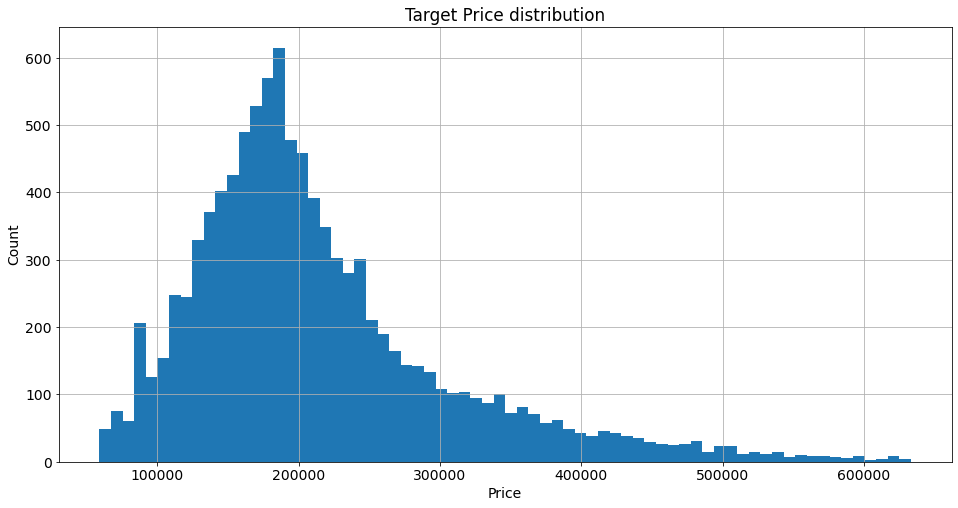

In [1223]:
plt.figure(figsize=(16, 8))

train_df['Price'].hist(bins = 70)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target Price distribution')
plt.show()

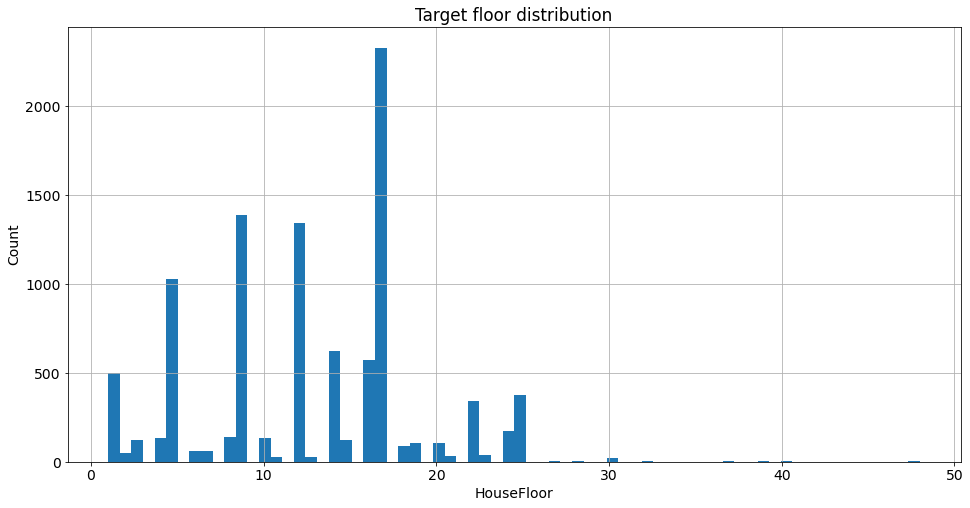

In [1224]:
plt.figure(figsize=(16, 8))

train_df['HouseFloor'].hist(bins = 70)
plt.ylabel('Count')
plt.xlabel('HouseFloor')

plt.title('Target floor distribution')
plt.show()

In [1225]:
feat = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare','Floor','HouseFloor', \
        'HouseYear','Ecology_1','Ecology_1','Ecology_2', 'Ecology_3',
        'Social_1','Social_2','Social_3', 'Healthcare_1','Helthcare_2', 'Shops_1',\
        'Shops_2','DistrictSize','MedPriceByDistrict']

x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [1226]:
forest = RandomForestRegressor()
forest.fit(x_train, y_train)

RandomForestRegressor()

Train R2:	0.966
Test R2:	0.759


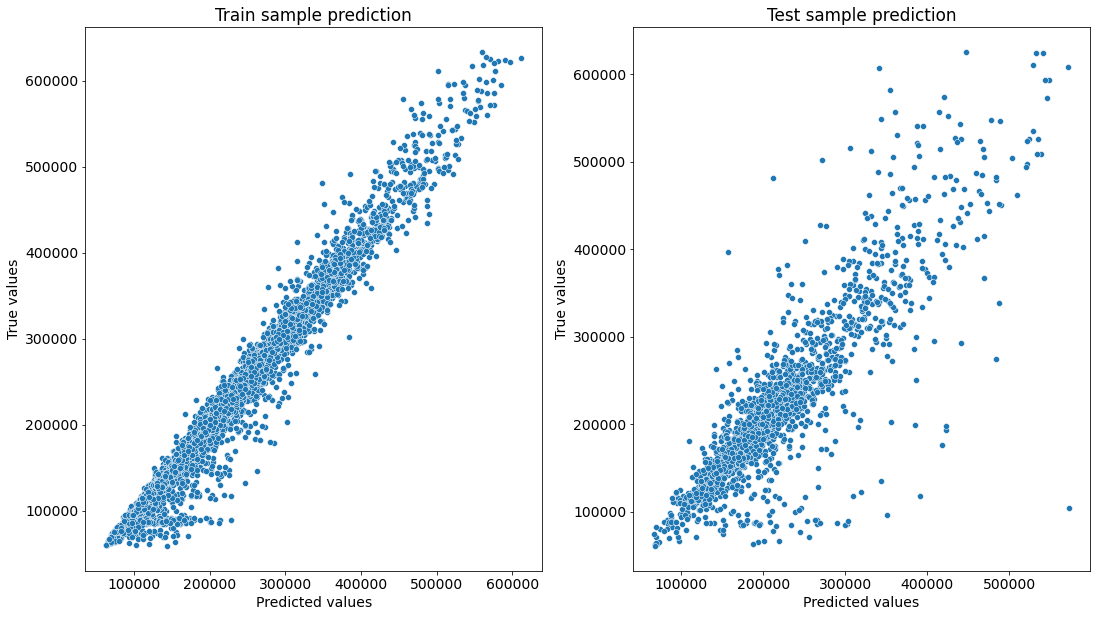

In [1227]:
train_pred = forest.predict(x_train)
test_pred = forest.predict(x_test)
evaluate_preds(y_train, train_pred, y_test, test_pred)

In [1228]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [1229]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698120,94.521461,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


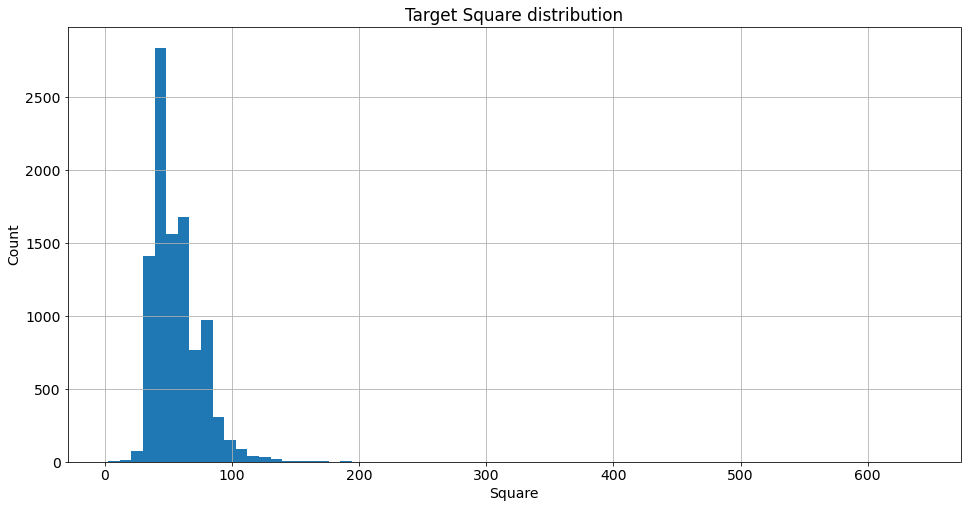

In [1230]:
plt.figure(figsize=(16, 8))

train_df['Square'].hist(bins = 70)
plt.ylabel('Count')
plt.xlabel('Square')

plt.title('Target Square distribution')
plt.show()

In [1231]:
test_df = dp.transform(test_df)

In [1232]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int16  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float32
 3   Square              5000 non-null   float32
 4   LifeSquare          5000 non-null   float32
 5   KitchenSquare       5000 non-null   float32
 6   Floor               5000 non-null   int8   
 7   HouseFloor          5000 non-null   float32
 8   HouseYear           5000 non-null   int16  
 9   Ecology_1           5000 non-null   float32
 10  Ecology_2           5000 non-null   bool   
 11  Ecology_3           5000 non-null   bool   
 12  Social_1            5000 non-null   int8   
 13  Social_2            5000 non-null   int16  
 14  Social_3            5000 non-null   int16  
 15  Healthcare_1        5000 non-null   float32
 16  Helthc

In [1233]:
feat = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare','Floor','HouseFloor', \
        'HouseYear','Ecology_1','Ecology_1','Ecology_2', 'Ecology_3',
        'Social_1','Social_2','Social_3', 'Healthcare_1','Helthcare_2', 'Shops_1',\
        'Shops_2','DistrictSize','MedPriceByDistrict']

x = test_df[feat]

result_pred = forest.predict(x)

In [1234]:
result_pred = np.around(result_pred, decimals=2)

In [1235]:
result = pd.concat([test_df['Id'], pd.Series(result_pred)],axis = 1)

In [1236]:
result.to_csv('talanov_prediction.csv', header=['ID', 'Predicted price'], index=False)